In [1]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/推荐系统/推荐系统算法复现/ml-100k")
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [ ]:
# 导入user_df和item_df
user_df = pd.read_csv("./user_df.csv")
user_df = user_df.iloc[:,1:]
user_df.index += 1
item_df = pd.read_csv("./item_df.csv")
item_df = item_df.iloc[:,1:]
item_df.index += 1
user_df.head()

,age,gender,occupation
1,2,9,29
2,5,8,23
3,2,9,30
4,2,9,29
5,3,8,23


In [ ]:
item_df.head()

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,30,31,32,34,35,36,36,37,38,39,40,41,42,43,44,45,46,47,48
2,30,32,33,33,34,35,36,37,38,39,40,41,42,43,44,45,47,47,48
3,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,47,48
4,30,32,32,33,34,36,36,37,39,39,40,41,42,43,44,45,46,47,48
5,30,31,32,33,34,35,37,37,39,39,40,41,42,43,44,45,47,47,48


In [ ]:
# 导入序列数据
sequential_df = pd.read_csv("./rnn_data_with_hist_label.csv")
sequential_df = sequential_df.iloc[:,1:]
data = sequential_df
data

,rating,user_id,item_id,timestamp,item_id_last1,item_id_last2,item_id_last3,item_id_last4,item_id_last5,rating_last1,rating_last2,rating_last3,rating_last4,rating_last5
0,1,1,196,874965677,166,156,165,172,168,1,1,1,1,1
1,1,1,187,874965678,196,166,156,165,172,1,1,1,1,1
2,1,1,250,874965706,187,196,166,156,165,1,1,1,1,1
3,1,1,127,874965706,250,187,196,166,156,1,1,1,1,1
4,1,1,14,874965706,127,250,187,196,166,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95280,0,943,450,888693158,229,449,840,151,1330,0,0,1,1,0
95281,0,943,230,888693158,450,229,449,840,151,0,0,0,1,1
95282,0,943,228,888693158,230,450,229,449,840,0,0,0,0,1
95283,0,943,227,888693158,228,230,450,229,449,0,0,0,0,0


In [ ]:
import numpy as np

# 设置随机数生成器的种子
np.random.seed(0)
# 创建一个1到10000的数组
arr = np.arange(data.shape[0])
# 原地随机排列数组
np.random.shuffle(arr)
# 选择百分之多少的数据作为训练集
train_test_ratio = 0.9
# 打乱后的数组的前百分之train_test_ratio(i.e.90%)作为训练集对应的index
train_index = arr[:int(len(arr)*train_test_ratio)]
# 打乱后的数组的后百分之(1-train_test_ratio)(i.e.10%)作为测试集对应的index
test_index = arr[int(len(arr)*train_test_ratio):]
# 获取训练集和测试集
train_set = data.iloc[train_index,:]
test_set = data.iloc[test_index, :]

# 将训练集和测试集的每一行都变成一个元组，方便后续处理
train_set = [tuple(row) for row in train_set.itertuples(index=False, name=None)]
test_set = [tuple(row) for row in test_set.itertuples(index=False, name=None)]

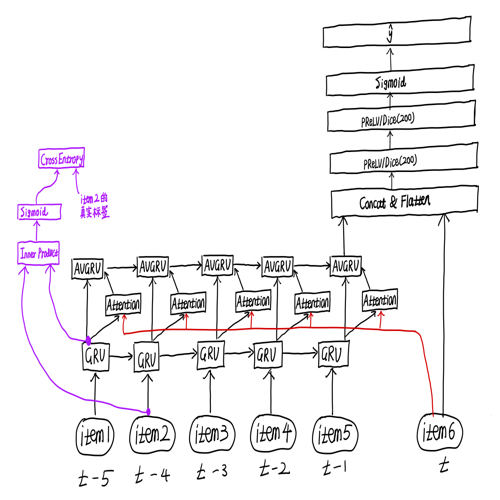

In [2]:
from PIL import Image
os.chdir("/content/drive/MyDrive/Colab Notebooks/推荐系统/推荐系统算法复现/图片")
image_path = "./DIEN.jpeg"
image = Image.open(image_path)
new_size = (500, 500)
resized_image = image.resize(new_size)
# 红色点表示：商品id，蓝色点表示：商铺id，白色点表示：其他id
resized_image

In [ ]:
from torch.nn import Parameter,init
#AUGRU单元
class AUGRU_Cell(nn.Module):

    def __init__(self, in_dim, hidden_dim ):
        '''
        :param in_dim: 输入向量的维度
        :param hidden_dim: 输出的隐藏层维度
        '''
        super( AUGRU_Cell, self ).__init__()

        # 初始化更新门的模型参数
        self.Wu = init.xavier_uniform_( Parameter( torch.empty( in_dim, hidden_dim ) ) )
        self.Uu = init.xavier_uniform_( Parameter( torch.empty( hidden_dim, hidden_dim ) ) )
        self.bu = init.xavier_uniform_( Parameter( torch.empty( 1, hidden_dim ) ) )

        # 初始化重置门的模型参数
        self.Wr = init.xavier_uniform_( Parameter( torch.empty( in_dim, hidden_dim ) ) )
        self.Ur = init.xavier_uniform_( Parameter( torch.empty( hidden_dim, hidden_dim ) ) )
        self.br = init.xavier_uniform_( Parameter( torch.empty( 1, hidden_dim ) ) )

        # 初始化计算h~的模型参数
        self.Wh = init.xavier_uniform_( Parameter( torch.empty( in_dim, hidden_dim ) ) )
        self.Uh = init.xavier_uniform_( Parameter( torch.empty( hidden_dim, hidden_dim ) ) )
        self.bh = init.xavier_uniform_( Parameter( torch.empty( 1, hidden_dim ) ) )

        # 初始化注意计算里的模型参数
        self.Wa = init.xavier_uniform_( Parameter( torch.empty(in_dim, in_dim) ) )

    #注意力的计算
    def attention( self, x, item ):
        '''
        :param x: 输入的序列中第t个向量 [ batch_size, in_dim ]
        :param item: 目标物品的向量 [ batch_size, in_dim ]
        :return: 注意力权重 [ batch_size, 1 ]
        '''
        # hW的shape为(batch_size, in_dim)
        hW = torch.matmul( x, self.Wa )
        # hwi的shape为(batch_size);hW*item的shape为(batch_size, in_dim)
        hWi = torch.sum( hW*item, dim=1 )
        # hwi的shape为(batch_size, 1)
        hWi = torch.unsqueeze( hWi, 1 )
        return torch.softmax( hWi, dim = 1 )

    def forward(self,x,h_1,item):
        '''
        :param x:  输入的序列中第t个物品向量 [ batch_size, in_dim ]
        :param h_1:  上一个AUGRU单元输出的隐藏向量 [ batch_size, hidden_dim ]
        :param item: 目标物品的向量 [ batch_size, in_dim ]
        :return: h 当前层输出的隐藏向量 [ batch_size, hidden_dim ]
        '''
        # u的shape为(batch_size, hidden_dim)
        u = torch.sigmoid( torch.matmul( x, self.Wu )+torch.matmul( h_1, self.Uu )+self.bu )
        # r的shape为(batch_size, hidden_dim)
        r = torch.sigmoid( torch.matmul( x, self.Wr )+torch.matmul( h_1, self.Ur )+self.br )
        # h_hat的shape为(batch_size, hidden_dim)
        h_hat = torch.tanh( torch.matmul( x, self.Wh )+r*torch.matmul( h_1, self.Uh )+self.bh )
        # a的shape为(batch_size, 1)
        a = self.attention( x, item )
        # u_hat的shape为(batch_size, hidden_dim)
        u_hat = a * u
        # h的shape为(batch_size, hidden_dim)
        h = ( 1 - u_hat ) * h_1 + u_hat * h_hat
        return h

In [ ]:
class AUGRU( nn.Module ):
    def __init__( self, in_dim, hidden_dim ):
        super( AUGRU, self ).__init__( )
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        # 初始化AUGRU单元
        self.augru_cell = AUGRU_Cell( in_dim, hidden_dim )

    def forward( self, x, item ):
        '''
        :param x: 输入的序列向量，维度为 [ batch_size, seq_lens, in_dim ]
        :param item: 目标物品的向量
        :return: outs: 所有AUGRU单元输出的隐藏向量[ batch_size, seq_lens, dim ]
                 h: 最后一个AUGRU单元输出的隐藏向量[ batch_size, hidden_dim ]
        '''
        outs = []
        h = None
        #开始循环，x.shape[1]是序列的长度
        for i in range( x.shape[1] ):
            if h==None:
                #初始化第一层的输入h
                h = init.xavier_uniform_( Parameter( torch.empty( x.shape[0], self.hidden_dim ) ) )
            # x[:,i]的shape为(batch_size, in_dim)
            # 输入和输出h的皆shape为(batch_size, hidden_dim)
            # item的shape为(batch_size, in_dim)
            h = self.augru_cell( x[:,i], h, item )
            outs.append( torch.unsqueeze( h, dim=1 ) )
        outs = torch.cat( outs, dim=1 )
        return outs, h

In [ ]:
# Dice激活单元
class Dice( nn.Module ):
    def __init__( self, a = 0.1 ):
        super( Dice, self ).__init__()
        self.a = a

    def forward( self, embs ):
        BN = nn.BatchNorm1d( embs.shape[1] )
        prob = torch.sigmoid( BN( embs ) )
        return prob * embs + ( 1 - prob ) * self.a * embs

In [ ]:
class DIEN(nn.Module):
  def __init__(self, num_features, hidden_dim, alpha = 0.1):
    super(DIEN, self).__init__()
    self.embedding = nn.Embedding(num_features, hidden_dim)
    self.GRU = nn.GRU(hidden_dim, hidden_dim, batch_first = True)
    self.AUGRU = AUGRU(hidden_dim, hidden_dim)
    self.BCELoss = nn.BCELoss( )
    self.mlp = nn.Sequential(nn.Linear( 2*hidden_dim, hidden_dim), Dice(),
                             nn.Linear( hidden_dim, int(hidden_dim/2)), Dice(),
                             nn.Linear( int(hidden_dim/2), 1), nn.Sigmoid())
    self.alpha = alpha #计算辅助损失函数时的权重

  #整体前向传播
  def forward(self, history_seqs, history_labels, target_item, target_label, if_predict = False):
    # history_seqs的shape为(batch_size, seq_len)
    # hist_item_embs的shape为(batch_size, seq_len, hidden_dim)
    hist_item_embs = self.embedding(history_seqs)

    # gru_outs是所有时间步的输出, _是最后一个时间步的隐藏状态(这里用不到_，因为gru_outs包含了_的结果)
    # gru_outs的shape为(batch_size, seq_len, hidden_dim)
    gru_outs, _ = self.GRU(hist_item_embs)

    #利用GRU输出的outs得到辅助损失函数
    # auxi_loss的shape为(batch_size)
    auxi_loss = self.forwardAuxiliary(gru_outs, hist_item_embs, history_labels.float() )

    # 利用GRU输出的outs与目标目标的向量输入进兴趣演化层的AUGRU网络, 得到最后一层的输出h
    # h的shape为(batch_size, hidden_dim)
    # target_item_embs的shape为(batch_size, hidden_dim)
    target_item_embs = self.embedding(target_item)
    _, h = self.AUGRU(gru_outs, target_item_embs)

    # 拼接h和target_item_embs
    # concat_vec的shape为(batch_size, 2*hidden_dim)
    concat_vec = torch.cat([target_item_embs, h], axis = 1)

    # 将concat_vec输入神经网络层
    # y_hat的shape为(batch_size, 1)
    y_hat = self.mlp(concat_vec)
    y_hat = torch.squeeze(y_hat)
    # 计算mlp部分损失
    mlp_loss = self.BCELoss(y_hat, target_label.float())

    if if_predict == False:
      return self.alpha *auxi_loss +  mlp_loss
    else:
      return y_hat

  def forwardAuxiliary(self, gru_outs, hist_item_embs, history_labels):
    # 输入的gru_outs的shape为(batch_size, seq_len, hidden_dim)
    # 输出的gru_outs的shape为(batch_size, seq_len-1, hidden_dim)
    gru_outs = gru_outs[:,:-1,:]
    # 输入的hist_item_embs的shape为(batch_size, seq_len, hidden_dim)
    # 输出的hist_item_embs的shape为(batch_size, seq_len-1, hidden_dim)
    hist_item_embs = hist_item_embs[:,1:,:]
    # 将gru_outs与hist_item_embs点乘
    # dot_out的shape为(batch_size, seq_len-1)
    dot_out = torch.sum(gru_outs * hist_item_embs,axis = 2)
    # dot_out的shape为(batch_size, seq_len-1)
    dot_out = torch.sigmoid(dot_out)
    # 输入的history_labels的shape为(batch_size, seq_len)
    # 输出的history_labels的shape为(batch_size, seq_len-1)
    history_labels = history_labels[:, :-1]
    # 计算交叉熵损失，bce_loss的shape为(batch_size)
    bce_loss = self.BCELoss(dot_out.reshape(-1),  history_labels.reshape(-1))
    return bce_loss

In [ ]:
def evaluation(y_pred, y_true):
  p = precision_score(y_true, y_pred)
  r = recall_score(y_true, y_pred)
  acc = accuracy_score(y_true,y_pred)
  return p,r,acc

In [ ]:
num_features, hidden_dims = max(data.item_id)+1, 32
model = DIEN(num_features, hidden_dims)

In [ ]:
# 实例化损失函数和优化器
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score,recall_score,accuracy_score
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)
loss_fn = nn.BCELoss()

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
  for x in DataLoader(train_set, batch_size=512, shuffle=True):
    # 构建历史物体id序列
    hist_item_id_cat = x[4]
    hist_item_id_cat = torch.unsqueeze(hist_item_id_cat, 1)
    for hist_item_id in x[5:9]:
      hist_item_id = torch.unsqueeze(hist_item_id, 1)
      hist_item_id_cat = torch.cat([hist_item_id_cat, hist_item_id],axis = 1)

    # 构建历史物体id对应的label
    hist_item_label_cat = x[-5]
    hist_item_label_cat = torch.unsqueeze(hist_item_label_cat, 1)
    for hist_item_label in x[-4:]:
      hist_item_label = torch.unsqueeze(hist_item_label, 1)
      hist_item_label_cat = torch.cat([hist_item_label_cat, hist_item_label],axis = 1)

    # 获取当前物体的id和label
    target_item = x[2]
    target_label = x[0]

    # 清空梯度
    optimizer.zero_grad()
    # 计算损失
    loss = model(hist_item_id_cat, hist_item_label_cat, target_item, target_label)
    # 反向传播
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}, Loss: {loss.item()}")

  # 训练集
  predictions = model(hist_item_id_cat, hist_item_label_cat, target_item, target_label, if_predict = True)
  y_pred = np.array([1 if i >= 0.5 else 0 for i in predictions])
  y_true = target_label.detach().numpy()
  precision, recall, acc = evaluation(y_pred, y_true)
  print('train: Precision {:.4f} | Recall {:.4f} | accuracy {:.4f}'.format(precision, recall, acc))


  #测试集
  test_set = data.iloc[test_index, :]
  hist_item_id_cat = torch.tensor(test_set.iloc[:,[4,5,6,7,8]].values)
  hist_item_label_cat = torch.tensor(test_set.iloc[:,[-1,-2,-3,-4,-5]].values)
  target_item = torch.tensor(test_set.iloc[:,2].values)
  target_label = torch.tensor(test_set.iloc[:,0].values)
  predictions = model(hist_item_id_cat, hist_item_label_cat, target_item, target_label, if_predict = True)
  y_pred = np.array([1 if i >= 0.5 else 0 for i in predictions])
  precision, recall, acc = evaluation(y_pred, target_label)
  print('test: Precision {:.4f} | Recall {:.4f} | accuracy {:.4f}'.format(precision, recall, acc))

  print('----------------------------------------------------------------------------------------')


Epoch 0, Loss: 0.7134822010993958
train: Precision 0.7067 | Recall 0.7465 | accuracy 0.6825
test: Precision 0.6807 | Recall 0.7204 | accuracy 0.6525
----------------------------------------------------------------------------------------
Epoch 1, Loss: 0.7357163429260254
train: Precision 0.6232 | Recall 0.6880 | accuracy 0.6389
test: Precision 0.6891 | Recall 0.6979 | accuracy 0.6528
----------------------------------------------------------------------------------------
Epoch 2, Loss: 0.6971948146820068
train: Precision 0.6928 | Recall 0.7361 | accuracy 0.6627
test: Precision 0.6824 | Recall 0.7083 | accuracy 0.6503
----------------------------------------------------------------------------------------
Epoch 3, Loss: 0.7004109621047974
train: Precision 0.6667 | Recall 0.7385 | accuracy 0.6746
test: Precision 0.6873 | Recall 0.7120 | accuracy 0.6557
----------------------------------------------------------------------------------------
Epoch 4, Loss: 0.6587813496589661
train: Precisi